In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [3]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

In [4]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label    

In [5]:
from functools import partial

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [6]:
base_model = keras.applications.xception.Xception(weights='imagenet', 
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input, 
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, 
                                 nesterov=True, decay=0.1)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], 
              loss_weights=[0.8, 0.2], 
              optimizer=optimizer, 
              metrics=['acc'])

In [7]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [8]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 29s 5s/step - loss: 1.3305 - dense_loss: 1.5649 - dense_1_loss: 0.3929 - dense_acc: 0.3250 - dense_1_acc: 0.3438
Epoch 2/2
5/5 [==============================] - 28s 5s/step - loss: 1.1797 - dense_loss: 1.4277 - dense_1_loss: 0.1880 - dense_acc: 0.5000 - dense_1_acc: 0.2438


In [9]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

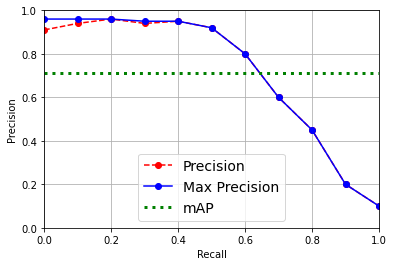

In [10]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()

plt.plot(recalls, precisions, 'ro--', label='Precision')
plt.plot(recalls, max_precisions, 'bo-', label='Max Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [mAP, mAP], 'g:', linewidth=3, label='mAP')
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower center', fontsize=14)
plt.show()

In [11]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
images_resized = tf.image.resize(images, [224, 224])
x = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, 
                                              strides=2, padding='VALID')
output = conv_transpose(x)
output.shape

TensorShape([2, 449, 449, 5])

In [12]:
def normalize(x):
    return (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))

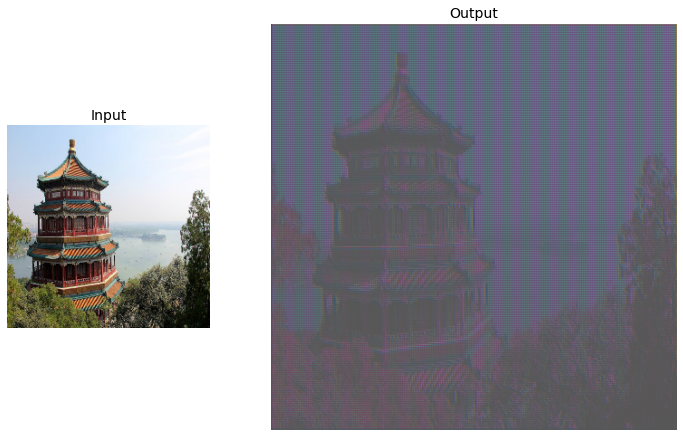

In [13]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(x[0])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation='bicubic')
ax2.axis('off')

plt.show()

In [14]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size, 
                        (height - 1) * stride + 2 * kernel_size - 1, 
                        (width - 1) * stride + 2 * kernel_size - 1, 
                        channels))
    upscaled[:, 
             kernel_size - 1:(height - 1) * stride + kernel_size:stride, 
             kernel_size - 1:(width - 1) * stride + kernel_size:stride, 
             :] = images
    return upscaled

In [15]:
upscaled = upscale_images(x, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding='VALID')

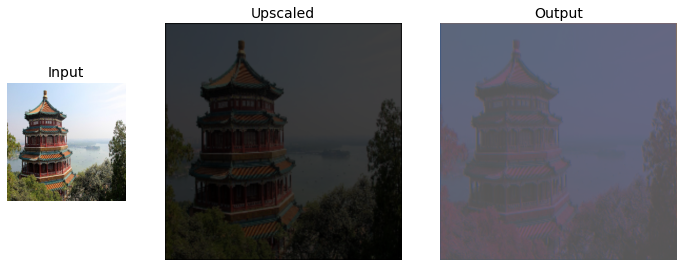

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(x[0])
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Upscaled', fontsize=14)
ax2.imshow(upscaled[0], interpolation='bicubic')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('Output', fontsize=14)
ax3.imshow(normalize(output[0, ..., :3]), interpolation='bicubic')
ax3.axis('off')

plt.show()

In [17]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True